# Install `PADL`


In [1]:
!python -m pip install git+https://github.com/lf1-io/padl.git

  Cloning https://github.com/lf1-io/padl.git to /private/var/folders/_j/9htwwr6x7hsdj_mb_1ws54cc0000gn/T/pip-req-build-3r23ewf0
  Running command git clone --filter=blob:none --quiet https://github.com/lf1-io/padl.git /private/var/folders/_j/9htwwr6x7hsdj_mb_1ws54cc0000gn/T/pip-req-build-3r23ewf0
  Resolved https://github.com/lf1-io/padl.git to commit ef3f3a5d1c28ea1956528c26d3dbeb18d9149bf2
  Preparing metadata (setup.py) ... done


In [2]:
# These might be useful if there are errors regarding ipywidgets while downloading torchvision.datasets
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

----

## Imports

Importing `padl` and most importantly `transform` decorator used to change any `callable` to `padl.Transform`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models

import padl
from padl import transform

## Dataset:
MNIST dataset available through torchvision is used in this notebook. The dataset can be separately downloaded from MNIST website or can be loaded as given below. 

More details on torchvision's MNIST dataset can be found here: https://pytorch.org/vision/stable/datasets.html#mnist

In [4]:
mnist_train_dataset = torchvision.datasets.MNIST('data', train=True, download=True)
mnist_test_dataset = torchvision.datasets.MNIST('data', train=False, download=True)

31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

96.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<hr style="border:1px solid"> </hr>


### 1. Plot few images to check the data

`plot_image` is a normal standard function that takes in an image tensor and uses `matplotlib.pyplot` to plot the image. With `@transform` decorator, we can easily convert it to `padl.transform`. This allows us to use `padl` functional api and build data pipeline easily and quickly. 

Quick recap to `padl` operators:
- `>>`: Compose operator: $(f_1 >> f_2)(x) \rightarrow f_2(f_1(x))$
- `+`: Rollout operator: $(f_1 + f_2) (x) \rightarrow (f_1(x), f_2(x))$
- `/`: Parallel operator: $(f_1 / f_2)((x_1,x_2)) \rightarrow (f_1(x_1), f_2(x_2))$
- `-`: Name operator: Names a transform so that its output can be accesed by given name or the transform itself can be accessed by its name from the pipeline:  
    - $((f_1 - \text{'zulu'})+f_2)(x) \rightarrow \text{Namedtuple}(\text{'zulu'}:f_1(x), \text{'out_1'}:f_2(x))$
    - $((f_1 - \text{'zulu'})+f_2)[\text{'zulu'}] = f_1$
    
Note that outputs of `Rollout` and `Parallel` are tuples.

For more details on operators and building Pipelines, refer to the documentation: https://lf1-io.github.io/padl/usage/transform.html

In [5]:
@transform
def plot_image(img_tensor):
    fig= plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    ax.imshow(img_tensor, cmap='gray')
    plt.axis('off')
    return fig

### 1.1 Building a simple plotting pipeline using `padl` operators

Description of inbuilt transforms used.

- `padl.same` is a self reflexive transform that allows for a quick mutation of input. 

        Example: padl.same[0]([1,2,3]) = 1

- `padl.Identity()` is a simple transform that does exactly as it sounds, passes the input on as it is. 

        Example: padl.Identity()([1,2,3]) = [1,2,3]



Description of `transform` pipeline defined below.
- `convert_plot`: Takes in a `PIL.Image` that is converted to numpy array, and then is plotted using `plot_image` transform defined above. 
- `plot_datapoint`: 
    - It is a `parrallel` that passes first part of input to convert_plot and passes second part of input as it is with `padl.Identity`
    - transforms are also named by `-`, so the output is a named tuple, with elements named as the transform name.




In [6]:
@transform
def img_to_array(img):
    return np.asarray(img)

convert_plot = (
    img_to_array
    >> plot_image
)

plot_datapoint = (convert_plot - 'image')/ (padl.Identity() - 'label')

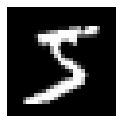

In [7]:
out = plot_datapoint(mnist_train_dataset[0])

In [8]:
out.label

5

Label : 4


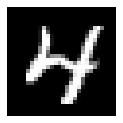

------------------------------
Label : 4


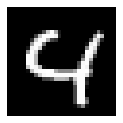

------------------------------
Label : 1


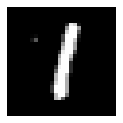

------------------------------
Label : 5


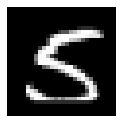

------------------------------
Label : 1


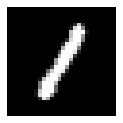

------------------------------


In [9]:
# Plotting some of the train datapoints

for _ in range(5):
    output = plot_datapoint(mnist_train_dataset[np.random.randint(len(mnist_train_dataset))])
    print(f'Label : {output.label}')
    # showing image
    plt.show()
    print('-'*30)

<hr style="border:1px solid"> </hr>


### 2. Model
We will build a simple neural net to classify `MNIST` handwritings. In the cell below, a simple pytorch net is defined with just one added decorator `@transform`. This is enough to wrap the pytorch model into `padl.Transform` and use it with other transform to build a data pipeline.

### 2.1 Simple net

In [11]:

import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

        
@transform
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Conv 1
        # size : input: 28x28x1 -> output : 26 x 26 x 32
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3)
        self.batchnorm1 = torch.nn.BatchNorm2d(32)
        
        # Conv 2
        # size : input: 26x26x32 -> output : 24 x 24 x 32
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3)
        self.batchnorm2 = torch.nn.BatchNorm2d(32)
        
        # Conv 3
        # size : input: 24x24x32 -> output : 12 x 12 x 32
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=2, stride = 2)
        self.batchnorm3 = torch.nn.BatchNorm2d(32)
        
        # Conv 4
        # size : input : 12 x 12 x 32 -> output : 8 x 8 x 64
        self.conv4 = torch.nn.Conv2d(32, 64, kernel_size=5)
        self.batchnorm4 = torch.nn.BatchNorm2d(64)
        
        # Conv 5
        # size : input: 8x8x64 -> output : 4 x 4 x 64 -> Linearize = 1024
        self.conv5 = torch.nn.Conv2d(64, 64, kernel_size=2, stride = 2)
        self.batchnorm5 = torch.nn.BatchNorm2d(64)
        
        # dropout layer 
        self.conv5_drop = torch.nn.Dropout2d()
        
        # FC 1 
        self.fc1 = torch.nn.Linear(1024, 128)
        
        # FC 2
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = self.batchnorm4(F.relu(self.conv4(x)))
        x = self.batchnorm5(F.relu(self.conv5(x)))
        x = self.conv5_drop(x)
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

### 2.2 Preprocessing

The `preprocess` pipeline below, again splits the datapoint to two different pipelines for `PIL.Image` and `int` label. First part of parralel pipeline, converts the image into torch tensor of type float, and second part passes the label as it is. The label later will be used for the loss function. 

In [12]:
@transform
def convert_to_tensor(img):
    arr = np.asarray(img)
    return torch.tensor(arr).type(torch.FloatTensor)


preprocess = (
    convert_to_tensor / convert_to_tensor
    >> padl.same.reshape(-1, 28, 28) / padl.Identity()
)

### 2.3 Instantiating the network and loss function

Initialising instances of `SimpleNet` and `loss` function. Loss function here is a wrapped `torch` negative log likelihood loss which is again wrapped easily with same `transform` call. 

In [13]:
simplenet = SimpleNet()
loss_func = transform(F.nll_loss)

In [14]:
simplenet

SimpleNet() - "simplenet":

   SimpleNet(
     (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
     (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
     (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
     (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
     (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv5): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
     (batchnorm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv5_drop): Dropout2d(p=0.5, inplace=False)
     (fc1): Linear(in_features=1024, out_features=128, bias=True)
     (fc2): Linear(in_featu

In [15]:
loss_func

nll_loss - "loss_func":

   def nll_loss(
       input: Tensor,
       target: Tensor,
       weight: Optional[Tensor] = None,
       size_average: Optional[bool] = None,
       ignore_index: int = -100,
       reduce: Optional[bool] = None,
       reduction: str = "mean",
   ) -> Tensor:
       r"""The negative log likelihood loss.

       See :class:`~torch.nn.NLLLoss` for details.

       Args:
           input: :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
               in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
               in the case of K-dimensional loss. `input` is expected to be log-probabilities.
           target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
               or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
               K-dimensional loss.
           weight (Tensor, optional): a manual rescaling weight given to each
               class. If given, has t

### 2.4  Building the training model

`train_model` is now composed (`>>`) with the transforms already defined.
- preprocess: preprocessing transform defined above
- Batchify: Batchify is a inbuilt `transform` that marks end of preprocess (dataloading) and that adds batch dimension to the inputs. Batchify also moves the input tensors to device specified for the model
- simplenet: Instance of SimpleNet
- padl.same: A self reflexive transform that allows for a quick mutation of input.

`train_model` is then sent to the intended device. It is by default in `cpu`.


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device to be used: ', device)

Device to be used:  cpu


In [17]:
train_model = (
    preprocess
    >> padl.Batchify()
    >> simplenet / padl.same.type(torch.long)
)

train_model.pd_to(device)

Compose - "train_model":

      │└────────────────────┐
      │                     │
      ▼ img                 ▼ img
   0: convert_to_tensor   / convert_to_tensor
      │                     │
      ▼ args                ▼ args
   1: reshape(-1, 28, 28) / Identity()       
      │
      ▼ args
   2: Batchify(dim=0)    
      │└────────────────────┐
      │                     │
      ▼ x                   ▼ args
   3: SimpleNet()         / type(torch.int64)

<hr style="border:1px solid"> </hr>


### 3. Training and validating the `train_model`

Training is not much different than the normal torch training steps, except dataloading and training is made even simplier by `train_apply`. It is one of the three inbuilt methods along with `infer_apply` and `eval_apply` that handles the mode context of model.

In [18]:
learning_rate = 0.01
momentum = 0.5
log_interval = 10
nepoch = 2
num_workers = 0

optimizer = optim.SGD(train_model.pd_parameters(), lr=learning_rate, momentum = momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.95)



for epoch in range(nepoch):
    step_counter = 0
    for batch_output, batch_targets in train_model.train_apply(mnist_train_dataset, num_workers=num_workers, batch_size=256):

        optimizer.zero_grad()

        loss = F.nll_loss(batch_output, batch_targets)

        loss.backward()

        optimizer.step()
        exp_lr_scheduler.step()

        if step_counter % log_interval == 0:
            print(f'Epoch:{epoch}; Step: {step_counter}; loss: {loss}')
        step_counter += 1

Epoch:0; Step: 0; loss: 2.32843279838562
Epoch:0; Step: 10; loss: 2.0219168663024902
Epoch:0; Step: 20; loss: 1.6625076532363892
Epoch:0; Step: 30; loss: 1.3506853580474854
Epoch:0; Step: 40; loss: 1.0103685855865479
Epoch:0; Step: 50; loss: 0.9072323441505432
Epoch:0; Step: 60; loss: 0.6765532493591309
Epoch:0; Step: 70; loss: 0.5504281520843506
Epoch:0; Step: 80; loss: 0.5161393880844116
Epoch:0; Step: 90; loss: 0.48721829056739807
Epoch:0; Step: 100; loss: 0.4040915369987488
Epoch:0; Step: 110; loss: 0.4484071135520935
Epoch:0; Step: 120; loss: 0.4975182116031647
Epoch:0; Step: 130; loss: 0.3997626006603241
Epoch:0; Step: 140; loss: 0.36582285165786743
Epoch:0; Step: 150; loss: 0.36289504170417786
Epoch:0; Step: 160; loss: 0.3392089605331421
Epoch:0; Step: 170; loss: 0.25499850511550903
Epoch:0; Step: 180; loss: 0.3611798882484436
Epoch:0; Step: 190; loss: 0.24412992596626282
Epoch:0; Step: 200; loss: 0.29443666338920593
Epoch:0; Step: 210; loss: 0.31384363770484924
Epoch:0; Step: 2

### 3.1 Accuracy of the model

We can quickly build a `validation_model` by adding a further step to `train_model` to get the number associated with the maximum confidence predicted by the model. 


Note: As we don't have a separate validation dataset with labels, we will have to use the same train data to `validate` the model in this example.


First, lets look at the format of the prediction by `infer_apply`ing one of datapoint.

In [19]:
train_model

Compose - "train_model":

      │└────────────────────┐
      │                     │
      ▼ img                 ▼ img
   0: convert_to_tensor   / convert_to_tensor
      │                     │
      ▼ args                ▼ args
   1: reshape(-1, 28, 28) / Identity()       
      │
      ▼ args
   2: Batchify(dim=0)    
      │└────────────────────┐
      │                     │
      ▼ x                   ▼ args
   3: SimpleNet()         / type(torch.int64)

In [20]:
train_model.infer_apply(mnist_train_dataset[0])

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


namedtuple(simplenet=tensor([[-5.2692, -6.7916, -5.2562, -0.9152, -8.7154, -0.5542, -7.0435, -6.5707,
         -4.5927, -6.9072]]), out_1=tensor([5]))

`train_model` predicts a tensor of confidence associated for the 10 numbers, and the index associated with the maximum of these confidence is the prediction by the model. Thus, we can add another transform to the same `train_model` to get that index associated with maximum of the confidence. 

Note that the new `validation_model` is a new instance of Transform but it contains same objects as `train_model` with added two new `transform`s. All the transform objects that are already in `train_model` is in `device` as assigned above, but the main `validation_model` object itself will have by default `cpu` device assigned. Thus, to move it to (or assign it with) correct device, we have to again call `pd_to(device)`.

In [21]:
validation_model = (
    train_model
    >> padl.transform(lambda x: x.max(1).indices) / padl.Identity()
)

# We need to send the validation_model to device again
validation_model.pd_to(device)

Compose - "validation_model":

      │└───────────────────────────┐
      │                            │
      ▼ img                        ▼ img
   0: convert_to_tensor          / convert_to_tensor
      │                            │
      ▼ args                       ▼ args
   1: reshape(-1, 28, 28)        / Identity()       
      │
      ▼ args
   2: Batchify(dim=0)           
      │└───────────────────────────┐
      │                            │
      ▼ x                          ▼ args
   3: SimpleNet()                / type(torch.int64)
      │                            │
      ▼ x                          ▼ args
   4: lambda x: x.max(1).indices / Identity()       

In [22]:
# Compute accuracy over the test dataset

accuracy = 0
for batch_output, batch_targets in validation_model.eval_apply(mnist_test_dataset, num_workers=0, batch_size=256):
    accuracy += (batch_targets == batch_output).sum()

accuracy = accuracy.item()/ len(mnist_test_dataset)
print(f'Accuracy of model: {accuracy}')

Accuracy of model: 0.9519


Not a bad accuracy of `~0.95` for a quick train model.

### 3.2 Infer few images from test data

Although we do not have labels for images in test data, we can still infer and verify the predictions ourselves. For that, we can again use model object `simplenet` that we have trained by using `train_model` and now stack it with other `transform`s to build an infer model.

In [23]:
infer_preprocess =(
    padl.same[0]
    >> convert_to_tensor
)
infer_model = (
    infer_preprocess
    >> padl.Batchify()
    >> padl.same.unsqueeze(1) 
    >> simplenet
    >> padl.transform(lambda x: x.max(1).indices)
)

infer_model.pd_to(device)

Compose - "infer_model":

      │
      ▼ args
   0: __getitem__(0)            
      │
      ▼ img
   1: convert_to_tensor         
      │
      ▼ args
   2: Batchify(dim=0)           
      │
      ▼ args
   3: unsqueeze(1)              
      │
      ▼ x
   4: SimpleNet()               
      │
      ▼ x
   5: lambda x: x.max(1).indices

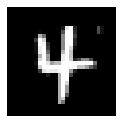

Prediction: 4
------------------------------


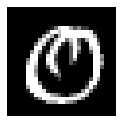

Prediction: 0
------------------------------


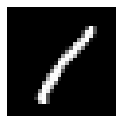

Prediction: 1
------------------------------


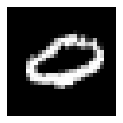

Prediction: 0
------------------------------


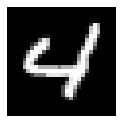

Prediction: 4
------------------------------


In [24]:
for _ in range(5):
    data_point = mnist_test_dataset[np.random.randint(len(mnist_test_dataset))]
    output = plot_datapoint(data_point)
    plt.show()
    print(f'Prediction: {infer_model.infer_apply(data_point).item()}')
    print('-'*30)

<hr style="border:1px solid"> </hr>


### 4. Using further image augmentation on training

We can easily use some of the `torchvision.transforms` for image augmentation and add it to our preproccessing of image to help with training. Lets add a couple of augmentations to our training: `GaussianBlur` and `RandomRotation`
We need to wrap the call to these `torchvision.transforms` with our `padl.transform` before instantiating them, and that is all. 

In [25]:
import torchvision.transforms as T

In [26]:
gaussian_blur = transform(T.GaussianBlur)(kernel_size=(3,3), sigma=0.1)

rotate_img = transform(T.RandomRotation)(degrees=(-15,15))

Now we can again use `padl`'s functional api to build an `image_augmentation` pipeline.

Note: `torchvision.transforms` expect images with channels but our images are just in grayscale. So, we need to unsqueeze our image tensor here.

In [27]:
image_augmentation = (
    padl.same.unsqueeze(0)
    >> rotate_img
    >> gaussian_blur
    >> padl.same[0]
)

####  Sample of image augmentation

Lets try the augmentation on one of image. 

tensor shape: torch.Size([28, 28])


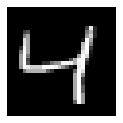

In [28]:
datapoint = mnist_train_dataset[2]

# plot datapoint 
plot_datapoint(datapoint)

# convert datapoint's image to tensor
img_tensor = convert_to_tensor(datapoint[0])

# tensor shape
print('tensor shape:', img_tensor.shape)

Augmented images: Running image augmentation on same image tensor

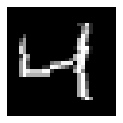

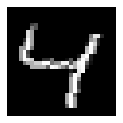

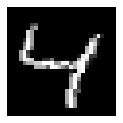

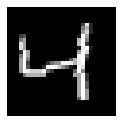

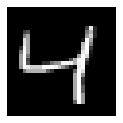

In [29]:
for _ in range(5):
    out_aug = image_augmentation(img_tensor)
    plot_image(out_aug)

### 4.2 We can add the `image_augmentation` pipeline easily to the `preprocess` and rebuild `train_model`

In [30]:
preprocess_with_augmentation = (
    convert_to_tensor / convert_to_tensor
    >> padl.same.reshape(-1, 28, 28) / padl.Identity()
    >> image_augmentation / padl.Identity()
)

train_model = (
    preprocess_with_augmentation
    >> padl.Batchify()
    >> simplenet / padl.same.type(torch.long)
)


train_model.pd_to(device)

Compose - "train_model":

      │└─────────────────────────────┐
      │                              │
      ▼ img                          ▼ img
   0: convert_to_tensor            / convert_to_tensor
      │                              │
      ▼ args                         ▼ args
   1: reshape(-1, 28, 28)          / Identity()       
      │                              │
      ▼ args                         ▼ args
   2: [image_augmentation: ..>>..] / Identity()       
      │
      ▼ args
   3: Batchify(dim=0)             
      │└─────────────────────────────┐
      │                              │
      ▼ x                            ▼ args
   4: SimpleNet()                  / type(torch.int64)

### 4.3 Retraining the model with `image_augmentation`

In [31]:
learning_rate = 0.01
momentum = 0.5
log_interval = 10
nepoch = 3
num_workers = 0

optimizer = optim.SGD(train_model.pd_parameters(), lr=learning_rate, momentum = momentum)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.95)



for epoch in range(nepoch):
    step_counter = 0
    for batch_output, batch_targets in train_model.train_apply(mnist_train_dataset, num_workers=num_workers, batch_size=256):

        optimizer.zero_grad()

        loss = F.nll_loss(batch_output, batch_targets)

        loss.backward()

        optimizer.step()
        exp_lr_scheduler.step()

        if step_counter % log_interval == 0:
            print(f'Epoch:{epoch}; Step: {step_counter}; loss: {loss}')
        step_counter += 1

Epoch:0; Step: 0; loss: 0.297992080450058
Epoch:0; Step: 10; loss: 0.26691189408302307
Epoch:0; Step: 20; loss: 0.3031817078590393
Epoch:0; Step: 30; loss: 0.2840678095817566
Epoch:0; Step: 40; loss: 0.2174217253923416
Epoch:0; Step: 50; loss: 0.29895099997520447
Epoch:0; Step: 60; loss: 0.23612485826015472
Epoch:0; Step: 70; loss: 0.1967872977256775
Epoch:0; Step: 80; loss: 0.19700726866722107
Epoch:0; Step: 90; loss: 0.1855168491601944
Epoch:0; Step: 100; loss: 0.20173048973083496
Epoch:0; Step: 110; loss: 0.266267865896225
Epoch:0; Step: 120; loss: 0.2561732530593872
Epoch:0; Step: 130; loss: 0.20615340769290924
Epoch:0; Step: 140; loss: 0.19320911169052124
Epoch:0; Step: 150; loss: 0.19195593893527985
Epoch:0; Step: 160; loss: 0.1940772980451584
Epoch:0; Step: 170; loss: 0.14146924018859863
Epoch:0; Step: 180; loss: 0.2638438045978546
Epoch:0; Step: 190; loss: 0.10949670523405075
Epoch:0; Step: 200; loss: 0.1676878184080124
Epoch:0; Step: 210; loss: 0.1917532980442047
Epoch:0; Step

### 4.4 Validate the model

In [32]:
# Calculate accuracy
accuracy = 0
for batch_output, batch_targets in validation_model.eval_apply(mnist_test_dataset, num_workers=0, batch_size=256):
    accuracy += (batch_targets == batch_output).sum()

accuracy = accuracy.item()/ len(mnist_test_dataset)
print(f'Accuracy of model: {accuracy}')

Accuracy of model: 0.9718
